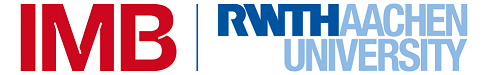

[Previous notebook: 7_1_mesh_sensitivity](./7_1_mesh_sensitivity.ipynb)

[Next notebook: 8_1_Mesh_bias_for_discretized_bar_with_linear_softening](./8_1_Mesh_bias_for_discretized_bar_with_linear_softening.ipynb)

# 7.2 Fracture energy and damage function

In [ ]:
%reset -f
%matplotlib inline
import sympy as sp
from sympy.plotting import plot as splot
sp.init_printing()

## Introduce the varialbes

In [ ]:
epsilon, epsilon_0, epsilon_f = sp.symbols('epsilon, epsilon_0, epsilon_f')
E_c, G_f = sp.symbols('E_c, G_f')
L_s, w = sp.symbols('L_s, w')
omega = sp.symbols('omega')
c_1, c_2 = sp.symbols('c_1,c_2', positive=True)
#f_t = sp.symbols('f_t') 
f_t = E_c * epsilon_0

In [ ]:
data = dict(E_c=28000, L_s=10.0, G_f=0.44, epsilon_0=3.0/28000)
data_girder = dict(E_c=28000, L_s=1.0, G_f=0.08, epsilon_0=3.0/28000)

### Softening function in terms of crack opening
Let's assume the softenig to follow an exponential function 
\begin{align}
f_{cw} = c_1 \exp(-c_2 w)
\end{align}
with two unknown parameters $c_1$ and $c_2$

In [ ]:
f_cw = c_1 * sp.exp(-c_2*w)
f_cw

To give the parametrers $c_1$ and $c_2$ let us consider two limiting situations:
 - The onset of softening starts level the matrix strength $f_t$ corresponding to zero crack opening $w=0$
 - The energy available for dissipation during the cracking has been totally consumed at the large crack opening $w=\infty$.
 
The first condition directly renders

In [ ]:
c1_subs = sp.solve( f_cw.subs({w:0}) - f_t, c_1 )[0]
c1_subs

The second condition is derived by evaluating the fracture energy. This can be done by integrating the softening law in the range of 
$w \in (0, \infty)$. The resulting equation is set equal to the fracture energy G_f and the parameter $c_2$ is resolved 

In [ ]:
int_f_cw = sp.integrate(f_cw.subs({c_1:c1_subs}), (w,0,sp.oo))
c2_subs = sp.solve(int_f_cw - G_f, c_2)[0]
c2_subs

By substituting for $c1$ and $c2$ into the the softening law we obtain 

In [ ]:
f_w = f_cw.subs({c_1 : c1_subs, c_2 : c2_subs})
f_w

Substitute the data parameters into this function and plot the softenig law for $w \in (0,1)$ 

In [ ]:
splot(f_w.subs(data),(w,0,1));

## Fracture energy - energy needed to produce stress free unit surface

Lst us now verify that the fracture energy gets recovered when quantifying the surface area below the softening law, first symbolically:

In [ ]:
int_G_f = sp.integrate(f_w,(w,0,w))
sp.limit(int_G_f,w,sp.oo)

Technical sympy remark - in the first expression, we could set the upper limit of integration range to infinty, i.e. sp.oo. However, because sympy must consider the values of other variables included in the expression, i.e. $E$, $G_f$ there is not a single. Indeed, for negative values of $G_f$ the solution is different. For this reason, we evaluated an indefinite integral by setting the upper limit again to $w$ and then evaluated the limit of the function for $w \rightarrow \infty$.   

### Verify the amount of fracture energy
Let us no substitute the data in to the integral expression and evaluate it for a large value of $w$ to check if the input value of $G_f$ is the same as the value of the integral.

In [ ]:
int_G_f.subs(data).subs({w:100})

## Transform the crack opening law to strain-softening law
By substituting the crack opening with displacement corresponding to a fracture strain expressed as
\begin{align}
\varepsilon_{\mathrm{f}} = \varepsilon - \varepsilon_0
\end{align}
multiplied by the length of the softening zone we obtain the softening law $\phi$ as

In [ ]:
phi_eps = f_w.subs({w: (epsilon-epsilon_0)*L_s} )
phi_eps

In [ ]:
data

In [ ]:
splot(phi_eps.subs(data), (epsilon,data['epsilon_0'],0.1), axis_center='auto');

### Define damage function as piecewise to include the elastic range
The damage function can be assembled in the form
\begin{align}
\omega(\varepsilon) = \left\{ 
\begin{array}{ll}
0  &   \varepsilon \le \varepsilon_0 \\
1 - \displaystyle{\frac{ \phi(\varepsilon - \varepsilon_0) }{E \varepsilon }}
 &   \varepsilon > \varepsilon_0
\end{array}
\right.
\end{align}

In [ ]:
omega_eps = sp.Piecewise(
    (0, epsilon<epsilon_0),
    (1 - phi_eps/E_c/epsilon, epsilon>=epsilon_0)
)
omega_eps

In [ ]:
splot(omega_eps.subs(data), (epsilon,1e-8,0.002));

### Show the monotonic stress-strain response
The derived damage function defined in terms of the strain allows us to use the standard format of damage model to obtain the stress-strain curve. 

In [ ]:
sig_eps = (1 - omega_eps) * E_c * epsilon
sig_eps

Given a data dictionary below let us plot the stress-strain curve

In [ ]:
data = dict(E_c=28000, L_s=0.1, G_f=0.044, epsilon_0=3.0/28000)
splot(sig_eps.subs(data), (epsilon,1e-8,0.1));

 - Question 1 - how to make the response of a single material point more brittle / more ductile?
 - Question 2 - what is the unit of fracture energy?

In [ ]:
data1 = dict(E_c=28000, L_s=1, G_f=0.1, epsilon_0=3.0/28000)
c1 = splot(sig_eps.subs(data1), (epsilon,1e-8,0.1), line_color="red");

In [ ]:
data2 = dict(E_c=28000, L_s=3, G_f=0.1, epsilon_0=3.0/28000)
c2 = splot(sig_eps.subs(data2), (epsilon,1e-8,0.1), line_color="green")
c1.extend(c2)
c1.show()

## Verify the amount of energy dissipated in the softenig zone
The damage function represents the deterioration of a unit volume of material. By integrating the stress-strain response for $\varepsilon\in(0,\infty)$ of a unit material volume we obtain the released specific energy with the unit [Jm$^{-3}$], i.e. [Nm$^{-2}$]. Thus, 
given a material law $\sigma(\varepsilon)$ exhibiting softening we can evaluate the energy released per unit volume as 
\begin{align}
g_\mathrm{F} = \int_0^\infty \sigma( \varepsilon ) \; \mathrm{d}\varepsilon.
\end{align}
If the material behavior prescribed by the function $\sigma(\varepsilon)$ affects a volume $V_\mathrm{c}$, the total energy released within this is obtained as
\begin{align}
\label{eq:int_G_f_eps}
G_\mathrm{F} = 
\int_{V_{\mathrm{c}}}
g_\mathrm{F} 
\; \mathrm{d}V
\end{align}
Thus, if we change the volume of the softening region $V_{\mathrm{c}}$, we obtain different response. This fact poses problems for numerical calculation using finite elements. Indeed, if we use a material model exhibiting softening in a finite element code, we obtain different results by changing the finte element mesh.

However, the fineness of the mesh is only a numerical aspect and should not affect the physical behavior of the structure. Therefore, we want to avoid such behavior and obtain mesh-independent results. 

The damage function obtained from the softening law derived above is very suitable to demonstrate the techniques that are used to avoid the mesh dependency. It explicitly contains the material inherent fracture energy $G_\mathrm{F}$. At the same time, it is able to adjust this energy to the prescribed length of softenig zone $L_\mathrm{s}$. When we include this damage function into the volume integral above we recover the value of $G_\mathrm{F}$ independently on $L_\mathrm{s}$.

Let us provide an example using the derived, damage fuction. The specific released energy is expressed as

In [ ]:
int_eps_g_f = sp.integrate(sig_eps,(epsilon,0,epsilon))
int_eps_g_f

As the strain and stress is constant within the softening volume, we can multiply the volume integral by the length of the softening zone and integrate for the strain history. By substituing large value of $varepsilon \rightarrow \infty$ into the expression for specific energy we obtain the total energy release. 

Taking the data set data1 with the length of the softening zone $L_\mathrm{s} = 1$ mm we obtain.

In [ ]:
int_eps_g_f1 = sp.integrate((sig_eps*L_s).subs(data1),(epsilon,0,epsilon))
int_g_f1 = int_eps_g_f1.subs({epsilon:1000})
int_g_f1

Apparently, this value agrees with the input value given in data set data1.

Let's perform the same evaluation for the data set data2 with $L_\mathrm{s} = 3$ mm.

In [ ]:
int_eps_g_f2 = sp.integrate((sig_eps*L_s).subs(data2),(epsilon,0,epsilon))
int_g_f2 = int_eps_g_f2.subs({epsilon:1000})
int_g_f2

## Generalization for arbitrary softening functions
The given example demonstrates the technique called mesh-adjusted softening function. The principle is to scale the stress strain curve depending on the size of the element.